In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt

In [3]:
DATSET = r'/kaggle/input/style-transfer-data'
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [1024, 1024, 1024, 256, 128, 64]
# BATCH_SIZES = [4,4,4,4,4,4,4]
CHANNELS_IMG = 3
Z_DIM = 256
W_DIM = 256
IN_CHANNELS = 256
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [10] * len(BATCH_SIZES)

In [4]:
print(DEVICE)

cuda


In [5]:
def get_loader(image_size):
    trainsform = transforms.Compose(
        [transforms.Resize((image_size, image_size)),
         transforms.ToTensor(),
         transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)],
         )
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size/4))]
    dataset = datasets.ImageFolder(root=DATSET, transform=trainsform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return loader, dataset

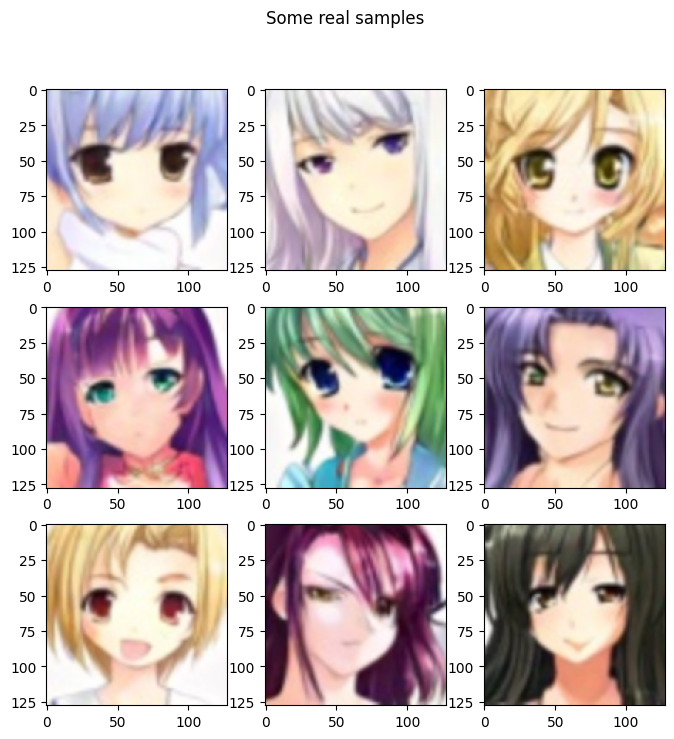

In [6]:
def check_loader():
    train_loader,_ = get_loader(128)
    # print(loader)
    cloth,_  = next(iter(train_loader))
    _,ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
            ind +=1
check_loader() 

In [7]:
# Noice apping network
# AdaIN
# Progressice growing
factors = [1, 1, 1, 1, 1/2, 1/4]

In [8]:
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias

In [9]:
class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)

In [10]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )
    
    def forward(self,x):
        return self.mapping(x)

In [11]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

In [12]:
class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + (self.weight * noise)

In [13]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


In [14]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

In [15]:
class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))
        
    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [16]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

In [17]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [18]:
def generate_examples(gen, steps, progressive_epoch, progressive_size, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/num_epochs_{progressive_epoch}_step_{steps}_image_size_{progressive_size}'):
                os.makedirs(f'saved_examples/num_epochs_{progressive_epoch}_step_{steps}_image_size_{progressive_size}')
            save_image(img*0.5+0.5, f"saved_examples/num_epochs_{progressive_epoch}_step_{steps}_image_size_{progressive_size}/img_{i}.png")
    gen.train()

In [19]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [25]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        
        # Generate fake images
        fake = gen(noise, alpha, step)
        
        # Calculate critic scores
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        
        # Calculate gradient penalty
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        
        # Critic loss
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )
        
        # Update critic
        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()
        
        # Generator loss and update
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        # Update alpha for progressive growing
        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        print("alpha", alpha)
        alpha = min(alpha, 1)
        
        Update progress bar
        loop.set_postfix(
            loss_generator=loss_gen.item(),
            gp=gp.item(),
            loss_critic=loss_critic.item()
        )
        
        # Monitor GPU memory every 50 batches
        if batch_idx % 50 == 0:
            for i in range(torch.cuda.device_count()):
                allocated = torch.cuda.memory_allocated(i) / 1e9
                print(f"GPU {i} memory: {allocated:.2f} GB")
    
    return alpha

In [26]:
path = r"/kaggle/working/model_ckpt"
if not os.path.exists(path):
    os.mkdir(path)

In [27]:
import torch
import gc
import os
from torch import optim

# Check available GPUs
print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"GPU Names: {[torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]}")

# Initialize models
gen = Generator(Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)

# Wrap models with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    gen = torch.nn.DataParallel(gen)
    critic = torch.nn.DataParallel(critic)

# Initialize optimizers
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.module.map.parameters() if isinstance(gen, torch.nn.DataParallel) else gen.map.parameters(), 'lr': 1e-5}], 
                    lr=LR, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LR, betas=(0.0, 0.99)
)

# Load checkpoint if available
checkpoint = None
#ckpt_path = r"/kaggle/input/dataset-style-gans/style_gan_checkpoint_res512.pth"
# if os.path.exists(ckpt_path):
#     print(f"Loading checkpoint from {ckpt_path}")
#     checkpoint = torch.load(os.path.join(ckpt_path))
    
#     # Handle loading state dict for DataParallel models
#     if torch.cuda.device_count() > 1:
#         gen.module.load_state_dict(checkpoint['generator'])
#         critic.module.load_state_dict(checkpoint['critic'])
#     else:
#         gen.load_state_dict(checkpoint['generator'])
#         critic.load_state_dict(checkpoint['critic'])
    
#     opt_gen.load_state_dict(checkpoint['opt_gen'])
#     opt_critic.load_state_dict(checkpoint['opt_critic'])
    
    # Restore other training parameters if needed
    # step = checkpoint['step']
    # alpha = checkpoint['alpha']

gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))

for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-3
    train_loader, train_dataset = get_loader(4*2**step)
    print('Current image size: '+str(4*2**step))
    
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}]')
        
        alpha = train_fn(
            critic, gen, train_loader, train_dataset, step, alpha, opt_critic, opt_gen
        )
    
    generate_examples(gen, step, num_epochs, 4*2**step)

    print("********************************************Completed image_size: "+ str(4*2**step))
    # Save checkpoint
    checkpoint = {
        'generator': gen.module.state_dict() if isinstance(gen, torch.nn.DataParallel) else gen.state_dict(),
        'critic': critic.module.state_dict() if isinstance(critic, torch.nn.DataParallel) else critic.state_dict(),
        'opt_gen': opt_gen.state_dict(),
        'opt_critic': opt_critic.state_dict(),
        'step': step,
        'alpha': alpha
    }
    torch.save(checkpoint, os.path.join(path, f'progressive_{num_epochs}_style_gan_checkpoint_res{4*2**step}.pth'))

    step += 1

Number of GPUs: 2
GPU Names: ['Tesla T4', 'Tesla T4']
Using 2 GPUs!
Current image size: 4
Epoch [1/ 10]


  3%|▎         | 1/36 [00:06<03:44,  6.41s/it]

alpha 0.0065743059335873705


  6%|▌         | 2/36 [00:12<03:37,  6.38s/it]

alpha 0.012148611867174742


  8%|▊         | 3/36 [00:19<03:30,  6.39s/it]

alpha 0.017722917800762114


 11%|█         | 4/36 [00:25<03:28,  6.51s/it]

alpha 0.023297223734349483


 14%|█▍        | 5/36 [00:32<03:21,  6.51s/it]

alpha 0.02887152966793685


 17%|█▋        | 6/36 [00:38<03:15,  6.52s/it]

alpha 0.03444583560152422


 19%|█▉        | 7/36 [00:45<03:08,  6.50s/it]

alpha 0.04002014153511159


 22%|██▏       | 8/36 [00:51<03:02,  6.50s/it]

alpha 0.04559444746869896


 25%|██▌       | 9/36 [00:58<02:56,  6.52s/it]

alpha 0.05116875340228633


 28%|██▊       | 10/36 [01:04<02:47,  6.45s/it]

alpha 0.056743059335873695


 31%|███       | 11/36 [01:11<02:42,  6.51s/it]

alpha 0.062317365269461064


 33%|███▎      | 12/36 [01:17<02:37,  6.54s/it]

alpha 0.06789167120304844


 36%|███▌      | 13/36 [01:24<02:31,  6.60s/it]

alpha 0.07346597713663582


 39%|███▉      | 14/36 [01:31<02:26,  6.65s/it]

alpha 0.07904028307022319


 42%|████▏     | 15/36 [01:38<02:20,  6.71s/it]

alpha 0.08461458900381057


 44%|████▍     | 16/36 [01:45<02:14,  6.72s/it]

alpha 0.09018889493739794


 47%|████▋     | 17/36 [01:51<02:07,  6.72s/it]

alpha 0.09576320087098532


 50%|█████     | 18/36 [01:58<02:00,  6.69s/it]

alpha 0.1013375068045727


 53%|█████▎    | 19/36 [02:04<01:52,  6.62s/it]

alpha 0.10691181273816007


 56%|█████▌    | 20/36 [02:11<01:45,  6.59s/it]

alpha 0.11248611867174745


 58%|█████▊    | 21/36 [02:18<01:39,  6.61s/it]

alpha 0.11806042460533482


 61%|██████    | 22/36 [02:24<01:32,  6.59s/it]

alpha 0.1236347305389222


 64%|██████▍   | 23/36 [02:31<01:25,  6.56s/it]

alpha 0.12920903647250956


 67%|██████▋   | 24/36 [02:37<01:18,  6.58s/it]

alpha 0.13478334240609693


 69%|██████▉   | 25/36 [02:44<01:12,  6.58s/it]

alpha 0.1403576483396843


 72%|███████▏  | 26/36 [02:50<01:05,  6.50s/it]

alpha 0.14593195427327169


 75%|███████▌  | 27/36 [02:57<00:59,  6.62s/it]

alpha 0.15150626020685906


 78%|███████▊  | 28/36 [03:03<00:52,  6.58s/it]

alpha 0.15708056614044644


 81%|████████  | 29/36 [03:10<00:45,  6.52s/it]

alpha 0.1626548720740338


 83%|████████▎ | 30/36 [03:17<00:40,  6.77s/it]

alpha 0.1682291780076212


 86%|████████▌ | 31/36 [03:24<00:34,  6.81s/it]

alpha 0.17380348394120856


 89%|████████▉ | 32/36 [03:31<00:27,  6.87s/it]

alpha 0.17937778987479594


 92%|█████████▏| 33/36 [03:38<00:20,  6.76s/it]

alpha 0.18495209580838332


 94%|█████████▍| 34/36 [03:44<00:13,  6.69s/it]

alpha 0.1905264017419707


 97%|█████████▋| 35/36 [03:51<00:06,  6.70s/it]

alpha 0.19610070767555807


100%|██████████| 36/36 [03:56<00:00,  6.58s/it]


alpha 0.2010000000000001
Epoch [2/ 10]


  3%|▎         | 1/36 [00:01<01:09,  1.97s/it]

alpha 0.20657430593358747


  6%|▌         | 2/36 [00:03<01:03,  1.88s/it]

alpha 0.21214861186717485


  8%|▊         | 3/36 [00:05<01:01,  1.87s/it]

alpha 0.21772291780076222


 11%|█         | 4/36 [00:07<00:59,  1.85s/it]

alpha 0.2232972237343496


 14%|█▍        | 5/36 [00:09<00:56,  1.83s/it]

alpha 0.22887152966793697


 17%|█▋        | 6/36 [00:11<00:54,  1.83s/it]

alpha 0.23444583560152435


 19%|█▉        | 7/36 [00:12<00:53,  1.84s/it]

alpha 0.24002014153511173


 22%|██▏       | 8/36 [00:15<00:53,  1.92s/it]

alpha 0.2455944474686991


 25%|██▌       | 9/36 [00:16<00:51,  1.92s/it]

alpha 0.25116875340228645


 28%|██▊       | 10/36 [00:18<00:48,  1.87s/it]

alpha 0.2567430593358738


 31%|███       | 11/36 [00:20<00:46,  1.85s/it]

alpha 0.2623173652694612


 33%|███▎      | 12/36 [00:22<00:44,  1.87s/it]

alpha 0.2678916712030486


 36%|███▌      | 13/36 [00:24<00:42,  1.86s/it]

alpha 0.27346597713663595


 39%|███▉      | 14/36 [00:26<00:40,  1.85s/it]

alpha 0.2790402830702233


 42%|████▏     | 15/36 [00:27<00:38,  1.86s/it]

alpha 0.2846145890038107


 44%|████▍     | 16/36 [00:29<00:36,  1.85s/it]

alpha 0.2901888949373981


 47%|████▋     | 17/36 [00:31<00:35,  1.85s/it]

alpha 0.29576320087098545


 50%|█████     | 18/36 [00:33<00:34,  1.91s/it]

alpha 0.30133750680457283


 53%|█████▎    | 19/36 [00:35<00:32,  1.94s/it]

alpha 0.3069118127381602


 56%|█████▌    | 20/36 [00:37<00:30,  1.93s/it]

alpha 0.3124861186717476


 58%|█████▊    | 21/36 [00:39<00:28,  1.91s/it]

alpha 0.31806042460533496


 61%|██████    | 22/36 [00:41<00:26,  1.93s/it]

alpha 0.32363473053892233


 64%|██████▍   | 23/36 [00:43<00:25,  1.93s/it]

alpha 0.3292090364725097


 67%|██████▋   | 24/36 [00:45<00:23,  1.92s/it]

alpha 0.3347833424060971


 69%|██████▉   | 25/36 [00:47<00:20,  1.90s/it]

alpha 0.34035764833968446


 72%|███████▏  | 26/36 [00:48<00:18,  1.88s/it]

alpha 0.34593195427327184


 75%|███████▌  | 27/36 [00:50<00:17,  1.90s/it]

alpha 0.3515062602068592


 78%|███████▊  | 28/36 [00:52<00:15,  1.91s/it]

alpha 0.3570805661404466


 81%|████████  | 29/36 [00:54<00:13,  1.91s/it]

alpha 0.36265487207403396


 83%|████████▎ | 30/36 [00:56<00:11,  1.89s/it]

alpha 0.36822917800762134


 86%|████████▌ | 31/36 [00:58<00:09,  1.89s/it]

alpha 0.3738034839412087


 89%|████████▉ | 32/36 [01:00<00:07,  1.89s/it]

alpha 0.3793777898747961


 92%|█████████▏| 33/36 [01:02<00:05,  1.91s/it]

alpha 0.38495209580838347


 94%|█████████▍| 34/36 [01:04<00:03,  1.88s/it]

alpha 0.39052640174197084


 97%|█████████▋| 35/36 [01:06<00:01,  1.87s/it]

alpha 0.3961007076755582


100%|██████████| 36/36 [01:07<00:00,  1.88s/it]


alpha 0.40100000000000025
Epoch [3/ 10]


  3%|▎         | 1/36 [00:01<01:03,  1.81s/it]

alpha 0.4065743059335876


  6%|▌         | 2/36 [00:03<01:02,  1.83s/it]

alpha 0.412148611867175


  8%|▊         | 3/36 [00:05<01:00,  1.84s/it]

alpha 0.41772291780076237


 11%|█         | 4/36 [00:07<00:58,  1.84s/it]

alpha 0.42329722373434975


 14%|█▍        | 5/36 [00:09<00:56,  1.83s/it]

alpha 0.4288715296679371


 17%|█▋        | 6/36 [00:11<00:55,  1.85s/it]

alpha 0.4344458356015245


 19%|█▉        | 7/36 [00:12<00:53,  1.83s/it]

alpha 0.4400201415351119


 22%|██▏       | 8/36 [00:14<00:51,  1.85s/it]

alpha 0.44559444746869925


 25%|██▌       | 9/36 [00:16<00:50,  1.87s/it]

alpha 0.4511687534022866


 28%|██▊       | 10/36 [00:18<00:50,  1.92s/it]

alpha 0.456743059335874


 31%|███       | 11/36 [00:20<00:48,  1.94s/it]

alpha 0.4623173652694614


 33%|███▎      | 12/36 [00:22<00:47,  1.99s/it]

alpha 0.46789167120304875


 36%|███▌      | 13/36 [00:24<00:45,  1.99s/it]

alpha 0.47346597713663613


 39%|███▉      | 14/36 [00:26<00:44,  2.01s/it]

alpha 0.4790402830702235


 42%|████▏     | 15/36 [00:29<00:43,  2.08s/it]

alpha 0.4846145890038109


 44%|████▍     | 16/36 [00:31<00:41,  2.05s/it]

alpha 0.49018889493739826


 47%|████▋     | 17/36 [00:33<00:38,  2.03s/it]

alpha 0.49576320087098563


 50%|█████     | 18/36 [00:34<00:36,  2.01s/it]

alpha 0.501337506804573


 53%|█████▎    | 19/36 [00:36<00:34,  2.00s/it]

alpha 0.5069118127381603


 56%|█████▌    | 20/36 [00:38<00:31,  1.99s/it]

alpha 0.5124861186717476


 58%|█████▊    | 21/36 [00:40<00:29,  1.96s/it]

alpha 0.518060424605335


 61%|██████    | 22/36 [00:42<00:27,  1.93s/it]

alpha 0.5236347305389223


 64%|██████▍   | 23/36 [00:44<00:24,  1.91s/it]

alpha 0.5292090364725096


 67%|██████▋   | 24/36 [00:46<00:23,  1.92s/it]

alpha 0.5347833424060969


 69%|██████▉   | 25/36 [00:48<00:21,  1.94s/it]

alpha 0.5403576483396842


 72%|███████▏  | 26/36 [00:50<00:19,  1.96s/it]

alpha 0.5459319542732716


 75%|███████▌  | 27/36 [00:52<00:17,  1.96s/it]

alpha 0.5515062602068589


 78%|███████▊  | 28/36 [00:54<00:15,  1.97s/it]

alpha 0.5570805661404462


 81%|████████  | 29/36 [00:56<00:13,  1.95s/it]

alpha 0.5626548720740335


 83%|████████▎ | 30/36 [00:58<00:11,  1.94s/it]

alpha 0.5682291780076208


 86%|████████▌ | 31/36 [01:00<00:09,  1.91s/it]

alpha 0.5738034839412082


 89%|████████▉ | 32/36 [01:02<00:07,  1.95s/it]

alpha 0.5793777898747955


 92%|█████████▏| 33/36 [01:04<00:05,  1.96s/it]

alpha 0.5849520958083828


 94%|█████████▍| 34/36 [01:06<00:03,  1.95s/it]

alpha 0.5905264017419701


 97%|█████████▋| 35/36 [01:07<00:01,  1.94s/it]

alpha 0.5961007076755575


100%|██████████| 36/36 [01:09<00:00,  1.94s/it]


alpha 0.6009999999999994
Epoch [4/ 10]


  3%|▎         | 1/36 [00:01<01:07,  1.94s/it]

alpha 0.6065743059335867


  6%|▌         | 2/36 [00:03<01:06,  1.95s/it]

alpha 0.6121486118671741


  8%|▊         | 3/36 [00:05<01:03,  1.93s/it]

alpha 0.6177229178007614


 11%|█         | 4/36 [00:07<01:01,  1.91s/it]

alpha 0.6232972237343487


 14%|█▍        | 5/36 [00:09<01:00,  1.94s/it]

alpha 0.628871529667936


 17%|█▋        | 6/36 [00:11<00:59,  2.00s/it]

alpha 0.6344458356015233


 19%|█▉        | 7/36 [00:13<00:57,  1.99s/it]

alpha 0.6400201415351107


 22%|██▏       | 8/36 [00:15<00:54,  1.96s/it]

alpha 0.645594447468698


 25%|██▌       | 9/36 [00:17<00:52,  1.95s/it]

alpha 0.6511687534022853


 28%|██▊       | 10/36 [00:19<00:51,  1.97s/it]

alpha 0.6567430593358726


 31%|███       | 11/36 [00:21<00:50,  2.00s/it]

alpha 0.66231736526946


 33%|███▎      | 12/36 [00:23<00:48,  2.00s/it]

alpha 0.6678916712030473


 36%|███▌      | 13/36 [00:25<00:45,  1.97s/it]

alpha 0.6734659771366346


 39%|███▉      | 14/36 [00:27<00:43,  1.97s/it]

alpha 0.6790402830702219


 42%|████▏     | 15/36 [00:29<00:41,  1.97s/it]

alpha 0.6846145890038092


 44%|████▍     | 16/36 [00:31<00:39,  1.96s/it]

alpha 0.6901888949373965


 47%|████▋     | 17/36 [00:33<00:37,  1.95s/it]

alpha 0.6957632008709839


 50%|█████     | 18/36 [00:35<00:35,  1.96s/it]

alpha 0.7013375068045712


 50%|█████     | 18/36 [00:37<00:37,  2.06s/it]


KeyboardInterrupt: 

In [ ]:
gen = Generator(Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)

In [ ]:
print(type(gen))

In [ ]:
# gen = Generator(Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
# critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)


# Initialize optimizers
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.module.map.parameters() if isinstance(gen, torch.nn.DataParallel) else gen.map.parameters(), 'lr': 1e-5}], 
                    lr=LR, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LR, betas=(0.0, 0.99)
)

# Load checkpoint if available
checkpoint = None
ckpt_path = r"/kaggle/input/st_gans/pytorch/default/1/model_ckpt/progressive_15_style_gan_checkpoint_res8.pth"
print(f"Loading checkpoint from {ckpt_path}")
checkpoint = torch.load(os.path.join(ckpt_path), map_location="cpu")

# Handle loading state dict for DataParallel models
if torch.cuda.device_count() > 1:
    gen.module.load_state_dict(checkpoint['generator'])
    critic.module.load_state_dict(checkpoint['critic'])
else:
    gen.load_state_dict(checkpoint['generator'])
    critic.load_state_dict(checkpoint['critic'])

opt_gen.load_state_dict(checkpoint['opt_gen'])
opt_critic.load_state_dict(checkpoint['opt_critic'])

step = checkpoint['step']
alpha = checkpoint['alpha']